# Visualization: Trading Session

In [90]:
import pandas as pd
import numpy as np

import altair as alt
import seaborn as sns

### 1. Define parameters and Load model

In [91]:
from trading_bot.agent import Agent

model_name = 'eurusd1m_20_old'
test_stock = 'data/EURUSD=X_1m_test.csv'
window_size = 10
debug = True

agent = Agent(window_size, pretrained=True, model_name=model_name)

### 2. Load test data

### 3. Running Eval

In [92]:
import logging
import coloredlogs

from trading_bot.utils import show_eval_result, switch_k_backend_device, get_stock_data
from trading_bot.methods import evaluate_model

coloredlogs.install(level='DEBUG')
switch_k_backend_device()

test_data = get_stock_data(test_stock)
initial_offset = test_data["Adj Close"][1] - test_data["Adj Close"][0]

test_result, history, actionCollection = evaluate_model(agent, test_data, window_size, debug)
show_eval_result(model_name, test_result, initial_offset)

2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG switching to TensorFlow for CPU
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.05


Data lerngth 909


2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $13.44
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Sell at: $14.67 | Position: +$0.61
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.05
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.05
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Sell at: $15.28 | Position: +$1.84
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.67
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.05
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Sell at: $15.28 | Position: +$1.23
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.67
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.05
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.05
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.05
2020-09-10 12:29:38 justin-desktop-ubunt

2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Sell at: $14.67 | Position: +$0.61
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Sell at: $15.89 | Position: +$1.84
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.67
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Sell at: $18.34 | Position: +$4.29
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.67
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.05
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Sell at: $15.28 | Position: +$1.23
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $13.44
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Buy at: $13.44
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Sell at: $14.05 | Position: +$0.61
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] DEBUG Sell at: $14.67 | Position: +$1.23
2020-09-10 12:29:38 justin-desktop-ubuntu root[13025] D

2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $15.28
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $15.28
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $15.28
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $15.89 | Position: +$0.61
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $15.89
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $15.89
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $15.89 | Position: +$0.61
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $16.50 | Position: +$1.23
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $15.89
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $17.73 | Position: +$2.45
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $15.89
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $15.89 | Position: +$0.61


2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $7.32
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $7.32
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $6.10
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $8.54
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $8.54
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $9.16
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $9.16
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $9.77 | Position: -$4.29
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $10.38 | Position: -$3.06
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $9.77
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $

2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $12.22
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.99
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $9.77
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.99
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $9.77
2020-09-10 12:29:39 justin-

2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $10.99 | Position: +$3.67
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $10.38
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $11.60 | Position: +$4.28
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $12.22 | Position: +$6.12
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $13.44 | Position: +$4.90
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $14.67 | Position: +$6.12
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Buy at: $13.44
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] DEBUG Sell at: $14.05 | Position: +$3.67
2020-09-10 12:29:39 justin-desktop-ubuntu root[13025] D

2020-09-10 12:29:40 justin-desktop-ubuntu root[13025] DEBUG Buy at: $12.22
2020-09-10 12:29:40 justin-desktop-ubuntu root[13025] DEBUG Buy at: $11.60
2020-09-10 12:29:40 justin-desktop-ubuntu root[13025] DEBUG Sell at: $12.83 | Position: +$0.61
2020-09-10 12:29:40 justin-desktop-ubuntu root[13025] DEBUG Buy at: $12.83
2020-09-10 12:29:40 justin-desktop-ubuntu root[13025] DEBUG Buy at: $11.60
2020-09-10 12:29:40 justin-desktop-ubuntu root[13025] DEBUG Buy at: $11.60
2020-09-10 12:29:40 justin-desktop-ubuntu root[13025] DEBUG Sell at: $12.83 | Position: +$1.22
2020-09-10 12:29:40 justin-desktop-ubuntu root[13025] DEBUG Sell at: $13.44 | Position: +$1.22
2020-09-10 12:29:40 justin-desktop-ubuntu root[13025] DEBUG Sell at: $13.44 | Position: +$1.22
2020-09-10 12:29:40 justin-desktop-ubuntu root[13025] DEBUG Sell at: $15.28 | Position: +$3.67
2020-09-10 12:29:40 justin-desktop-ubuntu root[13025] DEBUG Buy at: $14.05
2020-09-10 12:29:40 justin-desktop-ubuntu root[13025] DEBUG Sell at: $15.28

Final decision:  BUY  at  $3.05


In [93]:
len(actionCollection),len(test_data) # <- should be same length (minus one for current pred)

(909, 910)

In [94]:
test_data["realaction"] = np.sign(test_data["Close"].pct_change().shift(-1))
# we use 2 to sell, 1 to buy, 0 to hold
test_data["realaction"][test_data["realaction"]==-1.] = 2.
realActions = test_data["realaction"].values
# the last entry is the next day entry, we need to skip it
realActions = realActions[:-1]
test_data.head()

,High,Low,Close,Adj Close,Volume,realaction
0,14.052997,14.052997,14.052997,14.052997,0.0,0.0
1,14.052997,14.052997,14.052997,14.052997,0.0,0.0
2,14.052997,14.052997,14.052997,14.052997,0.0,2.0
3,13.440087,13.440087,13.440087,13.440087,0.0,1.0
4,14.052997,14.052997,14.052997,14.052997,0.0,0.0


In [95]:
#for i in range(15):
#    print(realActions[i],actionCollection[i])

In [96]:
# basic implementation
from sklearn.metrics import classification_report
target_names = ['hold', 'buy', 'sell']
cr = classification_report(realActions, actionCollection, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

        hold       0.47      0.32      0.38       367
         buy       0.35      0.55      0.43       262
        sell       0.48      0.41      0.44       280

    accuracy                           0.42       909
   macro avg       0.43      0.43      0.42       909
weighted avg       0.44      0.42      0.41       909



### 4. Visualize

In [97]:
try:
    df = pd.read_csv(test_stock,index_col="Datetime",parse_dates=["Datetime"])
except ValueError:
    df = pd.read_csv(test_stock,index_col="Date",parse_dates=["Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 910 entries, 2020-09-07 20:03:00+01:00 to 2020-09-08 11:20:44+01:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       910 non-null    float64
 1   High       910 non-null    float64
 2   Low        910 non-null    float64
 3   Close      910 non-null    float64
 4   Adj Close  910 non-null    float64
 5   Volume     910 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 49.8 KB


In [98]:
import backtrader as bt

class SmaCross(bt.Strategy):

    params = (
        ('allowshorts',1),
        ('printLog',False)
    )

    def __init__(self):
        self.pos = 0
        self.data_live = False
        self.isShort = False
        

    def next(self):
        for d in self.datas:
            # print(dn,self.crosses[d._name][0])
            pos = self.getposition(d).size
            if self.pos < len(actionCollection):
                action = actionCollection[self.pos]
                if not pos:  # no market / no orders
                    if action == 1:
                        self.buy(data=d)
                        self.isShort = False
                    elif action == 2 and self.p.allowshorts == 1:
                        self.sell(data=d)
                        self.isShort = True
                else:
                    if action == 1 and self.isShort:
                        self.close(data=d)
                        #self.buy(data=d)
                        #self.isShort = False
                    elif action == 2 and not self.isShort:
                        self.close(data=d)
                        #self.sell(data=d)
                        #self.isShort = True
            else:
                print("skip bc end of array")
            self.pos += 1

    def notify_trade(self, trade):
        dt = self.data.datetime.date()
        if trade.isclosed and self.p.printLog:
            print('{} {} Closed: PnL Gross {}, Net {}'.format(
                                                dt,
                                                trade.data._name,
                                                round(trade.pnl,2),
                                                round(trade.pnlcomm,2)))
            
    def notify_data(self, data, status, *args, **kwargs):
        if status == data.LIVE:
            self.data_live = True
            print("yay Live data!")


In [99]:
cerebro = bt.Cerebro(optreturn=True,maxcpus=None,cheat_on_open=True) # cheat on open bc i can instantly buy if signal appears
data = bt.feeds.PandasData(dataname=df)

startcash = 10000   
# Set our desired cash start
cerebro.broker.setcash(startcash)
# for stock in self.stocks:
cerebro.adddata(data)

# strategy
# cerebro.addstrategy(SmaCross, pfast=2,pslow=6) # not used bc opt strategy

cerebro.addstrategy(SmaCross) # https://backtest-rookies.com/2017/06/26/optimize-strategies-backtrader/


# cerebro.optstrategy(SmaCross, pfast=pfast,pslow=pslow) # https://backtest-rookies.com/2017/06/26/optimize-strategies-backtrader/

# add analyzer
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='SharpeRatio') #  timeframe=bt.TimeFrame.Months
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown') #  timeframe=bt.TimeFrame.Months
cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns') #  timeframe=bt.TimeFrame.Months
cerebro.addanalyzer(bt.analyzers.SQN, _name='SQN') #  timeframe=bt.TimeFrame.Months


# sizer
cerebro.addsizer(bt.sizers.PercentSizer, percents=98)

results = cerebro.run()
end = cerebro.broker.get_value() - startcash


skip bc end of array


2020-09-10 12:29:40 justin-desktop-ubuntu matplotlib.pyplot[13025] DEBUG Loaded backend module://ipykernel.pylab.backend_inline version unknown.


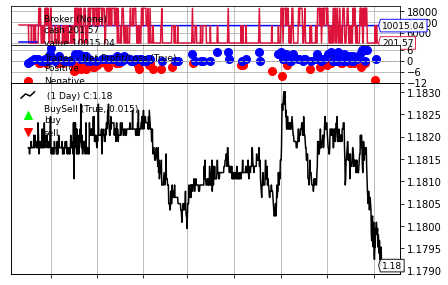

[[<Figure size 432x288 with 4 Axes>]]

In [100]:
%matplotlib inline
cerebro.plot(iplot=False)

In [101]:
def sqn_eval(nr):
    if nr <= 1.9:
        return "below average"
    elif nr <= 2.4:
        return "average"
    elif nr <= 2.9:
        return "good"
    elif nr <= 5.:
        return "excellent"
    elif nr <= 6.9:
        return "superb"
    elif nr > 6.9:
        return "HOLY GRAIL - $$$"
    else:
        return "ERROR"

def single_analytics(results,cerebro,startcash,printout=False):
    #sharpe
    sharper = results[0].analyzers.SharpeRatio.get_analysis()["sharperatio"]

    # drawdown
    maxdrawdown = results[0].analyzers.DrawDown.get_analysis().max.drawdown
    avgdrawdown = results[0].analyzers.DrawDown.get_analysis().drawdown
    # returns
    annualreturnpct = results[0].analyzers.Returns.get_analysis()["rnorm100"]
    monthlyreturnpct = annualreturnpct / 12
    # SQN SystemQualityNumber - https://www.backtrader.com/docu/analyzers-reference/
    sqn, nrtrades = results[0].analyzers.SQN.get_analysis()["sqn"],results[0].analyzers.SQN.get_analysis()["trades"]
    #Print out the final result
    if printout:
        print("\n")
        print('Sharpe Ratio: ', sharper)
        print("Avg Drawdown: %.2f pct, Max Drawdown: %.2f pct"%(avgdrawdown,maxdrawdown))
        print("Yearly return %.2f pct, Monthly return %.2f pct"%(annualreturnpct,monthlyreturnpct))
        print("SQN: %f, nr of trades: %d"%(sqn,nrtrades))
        print("SQN Evaluation: %s"%sqn_eval(sqn))
    return sharper,sqn,nrtrades,avgdrawdown,maxdrawdown,annualreturnpct,monthlyreturnpct

sharper,sqn,nrtrades,avgdrawdown,maxdrawdown,annualreturnpct,monthlyreturnpct = single_analytics(results,cerebro,startcash,printout=True)



Sharpe Ratio:  None
Avg Drawdown: 0.15 pct, Max Drawdown: 0.50 pct
Yearly return 20.86 pct, Monthly return 1.74 pct
SQN: 0.631517, nr of trades: 162
SQN Evaluation: below average


# data analysis

## eurusd 1m 10

Sharpe Ratio:  None

Avg Drawdown: 0.15 pct, Max Drawdown: 0.30 pct

Yearly return 66.65 pct, Monthly return 5.55 pct

SQN: 1.155293, nr of trades: 210

SQN Evaluation: below average